In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate()

  Activating environment at `/Volumes/GoogleDrive/My Drive/CMU/Research/QuadrotorDynamics/Project.toml`
Precompiling project...
  ✓ QuadrotorDynamics
  1 dependency successfully precompiled in 23 seconds (315 already precompiled)


In [2]:
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using PyPlot
using StaticArrays
using QuadrotorDynamics

┌ Info: Precompiling QuadrotorDynamics [f6d16423-25c2-4b6a-a4a4-258ba236e06a]
└ @ Base loading.jl:1342
┌ Warning: Package QuadrotorDynamics does not have BlockDiagonals in its dependencies:
│ - If you have QuadrotorDynamics checked out for development and have
│   added BlockDiagonals as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QuadrotorDynamics
└ Loading BlockDiagonals into QuadrotorDynamics from project dependency, future warnings for QuadrotorDynamics are suppressed.


In [3]:
h = 0.01  # timestep

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

kt = 1.0
g = QuadrotorDynamics.g
H = QuadrotorDynamics.H
qtorp = QuadrotorDynamics.qtorp
rptoq = QuadrotorDynamics.rptoq
qtoQ = QuadrotorDynamics.qtoQ
E = QuadrotorDynamics.E
L = QuadrotorDynamics.L
T = QuadrotorDynamics.T
R = QuadrotorDynamics.R
G = QuadrotorDynamics.G
Drptoq = QuadrotorDynamics.Drptoq

Drptoq (generic function with 1 method)

In [4]:
rotor = Rotor(false, 2, 0.165, 0.018, 0.0, 0.005, 0.010, 0.004, 0.0048, 0.0048*sqrt(0.0024), 6.8*π/180, 14.6*π/180, 5.5)
quad = QuadRotor(4., SMatrix{3,3}(Diagonal([0.082, 0.082, 0.149])), -0.007, 0.315, 0.05, 0.03, rotor, false)

u_hover = QuadrotorDynamics.hover_control(quad)
r0 = zeros(3)
q0 = [1.; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0]

13-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [53]:
data_dir = "/Users/sanjeev/Google Drive/My Drive/CMU/Research/QuadrotorDynamics/exps/good_exps/"
chunk_length = 10  # length of traj chunk to fit to at a time
# xs, ẋs, us, h = QuadrotorDynamics.read_cf_log(data_dir * "20220812_135052/merged.csv")


traj_paths = [
    "20220812_135052/merged.csv"
    # "20220812_135239/merged.csv"
    # "20220812_155559/merged.csv"
    ]
traj_full_paths = [data_dir * traj_path for traj_path in traj_paths]
xchunks = []
ẋchunks = []
uchunks = []
h = 0
for traj_full_path in traj_full_paths
    global h
    xs, ẋs, us, h = QuadrotorDynamics.read_cf_log(traj_full_path)
    QuadrotorDynamics.chunk_traj(xs, ẋs, us, xchunks, ẋchunks, uchunks, chunk_length)  # pushes to chunks list inplace
end
chunks = collect(zip(xchunks, ẋchunks, uchunks))

n = size(xchunks[1], 2)  # x dim
m = size(uchunks[1], 2)  # u dim
p = 3  # latent z dim

catter = (arr...) -> cat(arr...; dims=1)
xs = reduce(catter, xchunks)
us = reduce(catter, uchunks)
ẋs = reduce(catter, ẋchunks)
aero_params, regressor_matrix, aero_vector = QuadrotorDynamics.fit_aero(quad, eachrow(xs), eachrow(us), eachrow(ẋs))

([-0.09434405522543576, -0.14198493963238604, 0.13998970589862572, 0.5533672899863343, 0.19603233477354015, 0.1814877304693414, -0.05278820006860967, -0.14978238776264363, -0.5629829345393259, 0.10509748856117578, -0.5796538148817234, -0.31788214622012917, -44.32559816883244, -0.9694160016305323, -0.5289669367601886, -43.550911007362, -0.6687333796471449, -64.08867641338742], [0.002507708912529014 -0.0014383689057681141 … -0.0 0.0; 0.0 -0.0 … -0.0 0.0; … ; 0.0 -0.0 … -0.0 0.0; 0.0 -0.0 … -0.08170378299729858 0.02333058838488558], [-0.01634316819652737, 0.0007253033635777807, -39.23745151743924, -0.011297402125166615, -0.009167351918488942, -39.23988021982288, -0.02009894759135013, 0.014634552256934646, -39.24024030317583, -0.04268897653498036  …  -39.57585736599384, -0.48459951227364906, -0.7698439871779484, -39.59500181885634, -0.5025018502491033, -0.7513002454798674, -39.614146277467896, -0.5164124094096616, -0.7365816278403222, -39.6306742665639])

In [6]:
aero_params = nothing

In [54]:
A = ForwardDiff.jacobian(dx->QuadrotorDynamics.step(quad,dx,u_hover;h=h,grouped_aero_params=aero_params)[1], x0)
B = ForwardDiff.jacobian(du->QuadrotorDynamics.step(quad,x0,du;h=h,grouped_aero_params=aero_params)[1], u_hover)
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [55]:
# Cost weights
Qlqr = Array(100*I(Nx̃));
Rlqr = Array((1/844^2)*I(Nu));

#LQR Controller
K = dlqr(Ã,B̃,Qlqr,Rlqr);

In [9]:
#Feedback controller
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    u = u_hover - K*Δx̃
end

controller (generic function with 1 method)

In [96]:
function filter_state_prediction(xf,uf,Pf,h)
    rf = xf[1:3] #inertial frame
    qf = xf[4:7] #body to inertial
    vw = xf[8:10] #world frame
    vf = QuadrotorDynamics.A(qf)' * vw #body frame
    
    ab = xf[11:13] #accel bias
    ωb = xf[14:16] #gyro bias
    
    af = uf[1:3] #body frame
    ωf = uf[4:6] #body frame
    
    Qf = qtoQ(qf) #body to inertial
    
    #IMU Prediction
    y = rptoq(-0.5*h*(ωf-ωb))
    Y = qtoQ(y) #rotation from this time step to the next one
    rp = rf + h*Qf*vf
    qp = L(qf)*rptoq(0.5*h*(ωf-ωb))
    vpk = (vf + h*(af-ab - Qf'*[0; 0; g])) #new velocity in old body frame
    vp = Y*vpk #new velocity in new body frame
    
    #Jacobian
    dvdq = H'*(L(qf)*L(H*vf)*T + R(qf)'*R(H*vf))*G(qf) #This is the derivative of Q(q)*v w.r.t. q
    dgdq = H'*(L(qf)'*L(H*[0; 0; g]) + R(qf)*R(H*[0; 0; g])*T)*G(qf) #This is the derivative of Q(q)'*g w.r.t. q
    dvdb = 0.5*h*H'*(L(y)*L(H*vpk)*T + R(y)'*R(H*vpk))*Drptoq(-0.5*h*(ωf-ωb)) #This is the derivative of Y(ω-b)*vpk w.r.t. b
    Af = [I(3) h*dvdq h*Qf zeros(3,6);
          zeros(3,3) Y zeros(3,6) -0.5*h*G(qp)'*L(qf)*Drptoq(0.5*h*(ωf-ωb));
          zeros(3,3) -h*Y*dgdq Y -h*Y dvdb;
          zeros(6,9) I(6)]
    
    #Covariance Prediction
    Pp = Af*Pf*Af' + Vf
    
    return [rp; qp; vp; ab; ωb], Pp
end

#Filter measurement Jacobian
Cf = [I(3) zeros(3,12); zeros(3,3) I(3) zeros(3,9)];

function filter_mocap_update(xf,Pf,mocap)
    rf = xf[1:3] #inertial frame
    qf = xf[4:7] #body to inertial
    vf = xf[8:10] #body frame
    
    ab = xf[11:13] #accel bias
    ωb = xf[14:16] #gyro bias
    
    rm = mocap[1:3] #body frame
    qm = mocap[4:7] #body frame
    
    z = [rm-rf; qtorp(L(qf)'*qm)] #Innovation
    S = Cf*Pf*Cf' + Wf; #Innovation variance
    Lf = Pf*Cf'*S^-1; #Kalman Filter gain
    
    Δx̃ = Lf*z
    
    xn = [rf + Δx̃[1:3]; L(qf)*rptoq(Δx̃[4:6]); vf + Δx̃[7:9]; ab + Δx̃[10:12]; ωb + Δx̃[13:15]]
    Pn = (I-Lf*Cf)*Pf*(I-Lf*Cf)' + Lf*Wf*Lf'
    
    return xn, Pn
end

filter_mocap_update (generic function with 1 method)

In [78]:

#Measurement Functions

function imu_measurement(x,u)
    # return [(1/m)*[zeros(2,4); kt*ones(1,4)]*u; x[11:13]] + IMU_BIAS + sqrt(Vf)[1:6,1:6]*randn(6)
    return [(1/m)*B[1:3,:]*u; x[11:13]] + IMU_BIAS + sqrt(Vf)[1:6,1:6]*randn(6)
end

function gyro_measurement(x)
    return x[11:13] + IMU_BIAS[4:6] + sqrt(Vf)[4:6,4:6]*randn(3)
end

function mocap_measurement(x)
    #return x[1:7]
    return [x[1:3] + sqrt(Wf)[1:3,1:3]*randn(3); L(x[4:7])*rptoq(sqrt(Wf)[4:6,4:6]*randn(3))]
end

mocap_measurement (generic function with 1 method)

In [106]:
#Simulation Setup
#true state
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+0.05*randn(3); L(q0)*rptoq(0.005*randn(3)); v0; ω0] 
# xhist[:,1] .= x0

#controls
uhist = zeros(Nu,Nt)

#measurements
IMU_BIAS = 0.1*randn(6)
imuhist = zeros(6,Nt)
mocaphist = zeros(7,Nt)

#filter state
xf = zeros(16,Nt)
xf[:,1] .= [x0[1:10]; zeros(6)];

#controller state
xc = zeros(Nx,Nt)
xc[:,1] .= x0;

#filter covariance
Pf = zeros(15,15,Nt)
Pf[:,:,1] .= 1.0*I(15)

Wf = 0.0001*I(6) #measurement coviariance (mocap)
Vf = Diagonal([0.0001*ones(9); 1e-6*ones(6)]); #process covariance (IMU)

In [107]:
#Closed-Loop Simulation
for k = 1:(Nt-1)
    
    uhist[:,k] .= controller(xc[:,k])
    
    xhist[:,k+1] .= QuadrotorDynamics.step(quad, xhist[:,k],uhist[:,k]; h=h, grouped_aero_params=aero_params)[1]
    
    imuhist[:,k] .= imu_measurement(xhist[:,k],uhist[:,k])
    xpred, Ppred = filter_state_prediction(xf[:,k],imuhist[:,k],Pf[:,:,k],h)
    
    #Using the predicted state from the filter in the controller.
    #This is equivalent to a one time-step delay in the Mocap measurements
    
    xc[:,k+1] .= [xpred[1:10]; gyro_measurement(xhist[:,k+1])-xpred[14:16]]
    
    mocaphist[:,k+1] .= mocap_measurement(xhist[:,k+1])
    xf[:,k+1], Pf[:,:,k+1] = filter_mocap_update(xpred,Ppred,mocaphist[:,k+1])
    
    #Using the updated state from the filter in the controller.
    #This is equivalent to no delay on the Mocap measurements
    #xc[:,k+1] = [xf[1:10,k+1]; gyro_measurement(xhist[:,k+1])-xpred[14:16]]
end

In [111]:
#Closed-Loop Simulation (no filter)
for k = 1:(Nt-1)
    
    uhist[:,k] .= controller(xc[:,k])
    
    xhist[:,k+1] .= QuadrotorDynamics.step(quad, xhist[:,k],uhist[:,k]; h=h, grouped_aero_params=aero_params)[1]
    
#     imuhist[:,k] .= imu_measurement(xhist[:,k],uhist[:,k])
#     xpred, Ppred = filter_state_prediction(xf[:,k],imuhist[:,k],Pf[:,:,k],h)
    
#     #Using the predicted state from the filter in the controller.
#     #This is equivalent to a one time-step delay in the Mocap measurements
    
    xc[:,k+1] .= xhist[:,k+1]
    
#     mocaphist[:,k+1] .= mocap_measurement(xhist[:,k+1])
#     xf[:,k+1], Pf[:,:,k+1] = filter_mocap_update(xpred,Ppred,mocaphist[:,k+1])
    
    #Using the updated state from the filter in the controller.
    #This is equivalent to no delay on the Mocap measurements
    #xc[:,k+1] = [xf[1:10,k+1]; gyro_measurement(xhist[:,k+1])-xpred[14:16]]
end

## Visualization

In [15]:
jac = ForwardDiff.jacobian(x->QuadrotorDynamics.step(quad, x, u_hover; grouped_aero_params=aero_params, h=h)[2], x0)

13×13 Matrix{Float64}:
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.5  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.5  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.5
 0.0  0.0  0.0    0.0    0.0   -19.62  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0   19.62    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -19.62   0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0    0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
eigvals(jac)

13-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [98]:
jac_controller = ForwardDiff.jacobian(x->QuadrotorDynamics.step(quad, x, controller(x); grouped_aero_params=aero_params, h=h)[2], x0)

13×13 Matrix{Float64}:
  0.0            0.0            0.0          …     0.0            0.0
  0.0            0.0            0.0                0.0            0.0
  0.0            0.0            0.0                0.0            0.0
  0.0            0.0            0.0                0.0            0.0
  0.0            0.0            0.0                0.0            0.0
  0.0            0.0            0.0          …     0.5            0.0
  0.0            0.0            0.0                0.0            0.5
  0.0            0.0            0.0                0.0            0.0
  0.0            0.0            0.0                0.0            0.0
  1.80163e-9    -5.55562e-8   -60.8147            -3.38573e-11   -4.43158e-10
 -9.27809e-11  -96.5174        -1.42048e-9   …    -1.43176e-14   -9.87091e-10
 96.5174         2.81915e-7    -4.60699e-8      -101.807         -1.16803e-8
 -5.31305e-11   -6.98038e-10   -1.69958e-10        2.13075e-13  -19.5738

In [99]:
eigvals(jac_controller)

13-element Vector{ComplexF64}:
  -96.45691347208636 + 0.0im
  -96.45691347185915 + 0.0im
  -60.80650958238193 + 0.0im
  -19.07367452532161 + 0.0im
 -2.1768509658375352 - 2.261616423521563im
 -2.1768509658375352 + 2.261616423521563im
 -2.1768509657799724 - 2.2616164239312218im
 -2.1768509657799724 + 2.2616164239312218im
  -1.000135256444153 + 0.0im
 -0.9962005815153052 + 0.0im
 -0.9962005805440894 + 0.0im
 -0.5001718839002444 + 0.0im
                 0.0 + 0.0im

In [100]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /Users/sanjeev/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8704))

In [101]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [112]:
X1 = [SVector{13}(x) for x in eachcol(xhist)];
visualize!(vis, model, thist[end], X1)

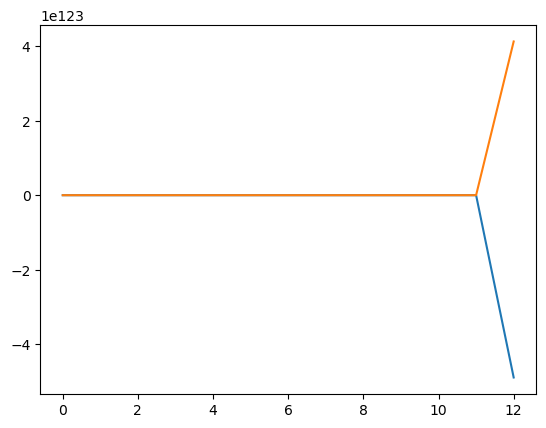

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa261baa00>

In [109]:
plot(xf[1,:])
plot(xhist[1,:])

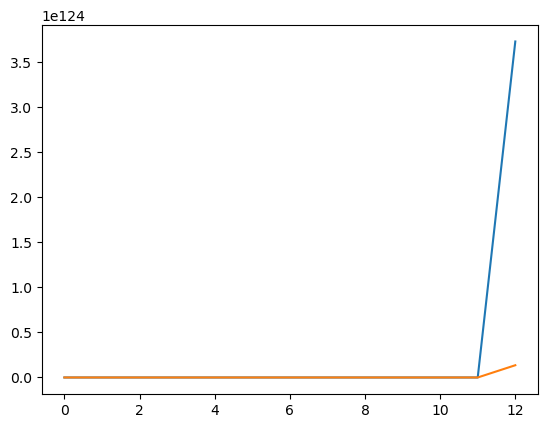

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa265037c0>

In [110]:
plot(xf[2,:])
plot(xhist[2,:])

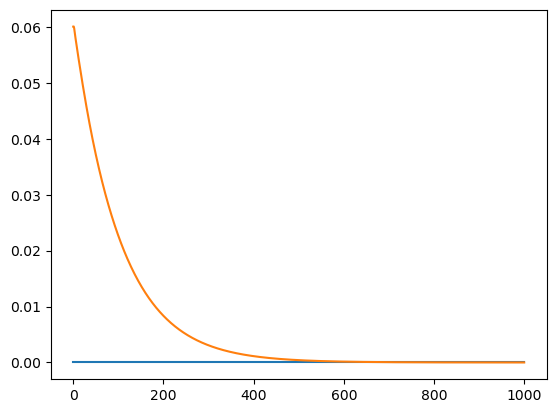

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa3b7c8160>

In [24]:
plot(xf[3,:])
plot(xhist[3,:])

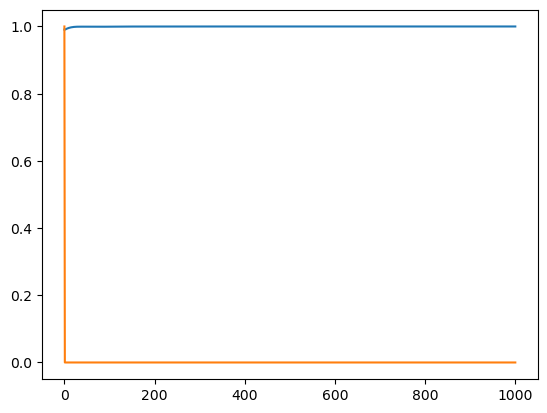

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa3d3d64f0>

In [25]:
plot(xhist[4,:])
plot(xf[4,:])

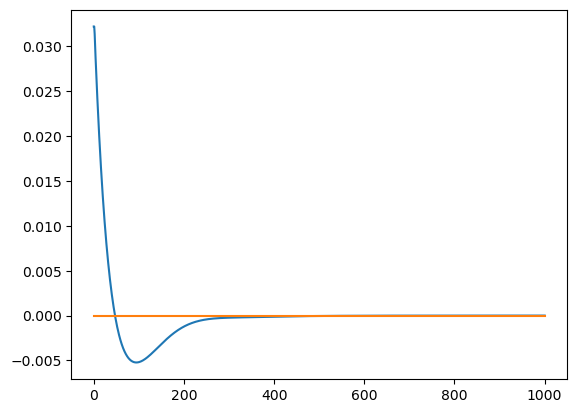

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa404862e0>

In [26]:
plot(xhist[5,:])
plot(xf[5,:])

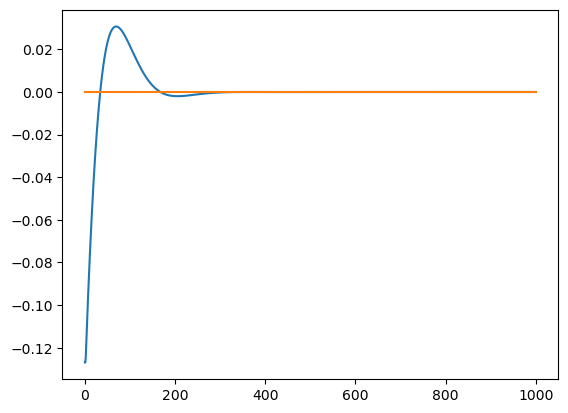

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa404ebc40>

In [27]:
plot(xhist[6,:])
plot(xf[6,:])

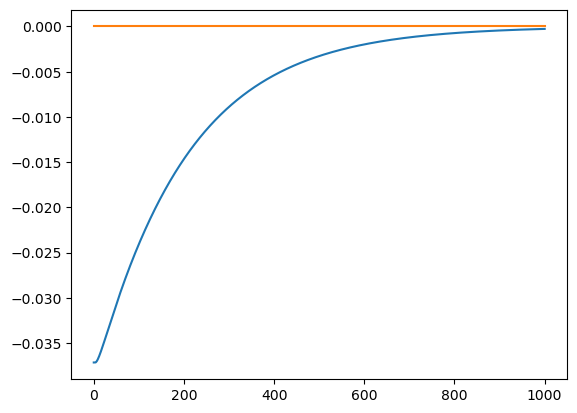

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa428e46a0>

In [28]:
plot(xhist[7,:])
plot(xf[7,:])

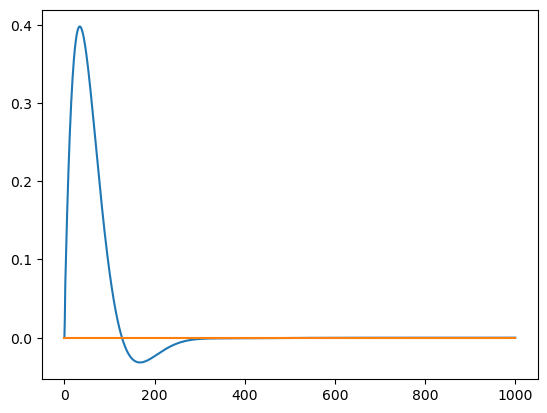

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa42b2a0a0>

In [29]:
plot(xhist[8,:])
plot(xf[8,:])

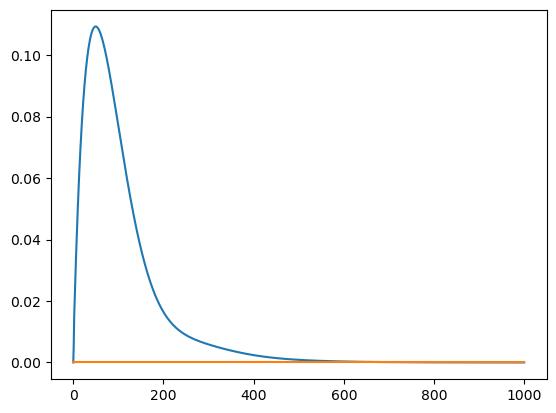

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa42b87880>

In [30]:
plot(xhist[9,:])
plot(xf[9,:])

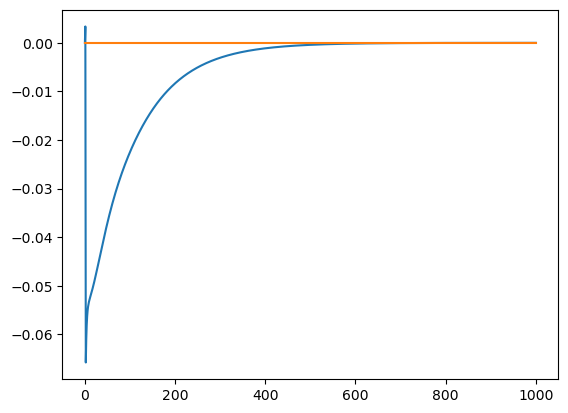

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa42bef610>

In [31]:
plot(xhist[10,:])
plot(xf[10,:])

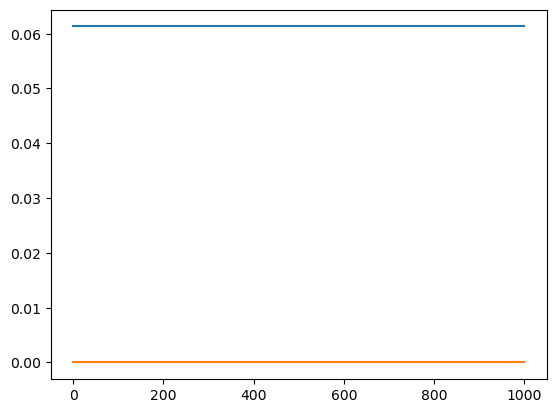

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa42c569a0>

In [32]:
plot(IMU_BIAS[1]*ones(Nt))
plot(xf[11,:])

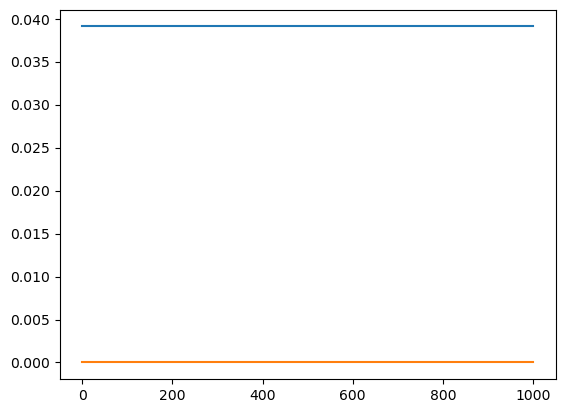

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa42ea5d30>

In [33]:
plot(IMU_BIAS[2]*ones(Nt))
plot(xf[12,:])

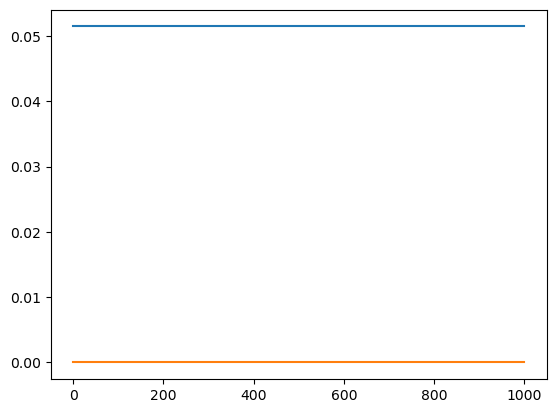

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa430f8bb0>

In [34]:
plot(IMU_BIAS[3]*ones(Nt))
plot(xf[13,:])

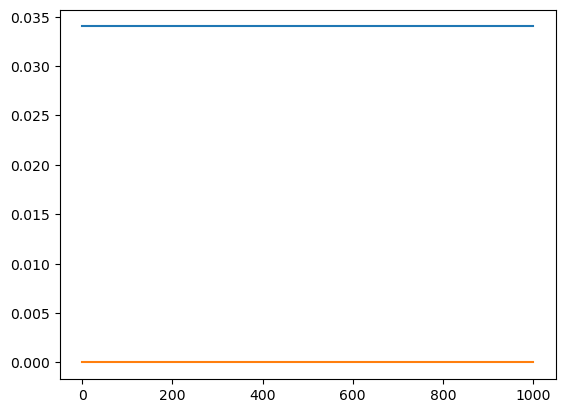

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa43156af0>

In [35]:
plot(IMU_BIAS[4]*ones(Nt))
plot(xf[14,:])

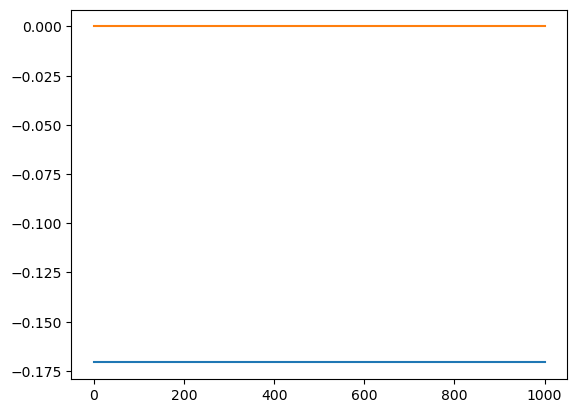

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa432fe460>

In [36]:
plot(IMU_BIAS[5]*ones(Nt))
plot(xf[15,:])

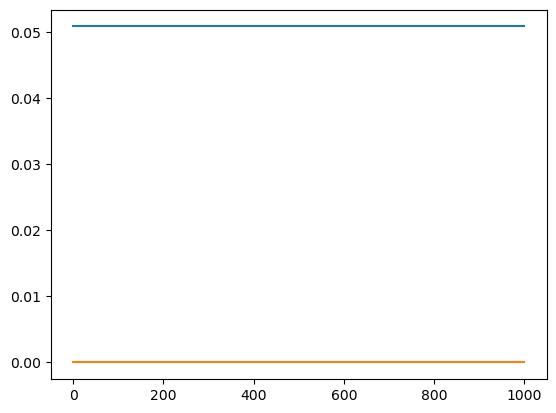

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa43383d90>

In [37]:
plot(IMU_BIAS[6]*ones(Nt))
plot(xf[16,:])